# ML for Time Series

## A Unified Framework for Structured Graph Learning via Spectral Constraints

Baptiste Collet - Cyril Miras

## Experiments

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as skd
import sklearn.metrics as skm
from learnGraphTopology import *

## Popular synthetic datasets

In [19]:
def dist_mat_exp_kernel(x, sigma=1, eps=1, k=None):
    n, d = x.shape
    dist_mat = np.zeros((n, n))
    for i in range(n):
        dist_mat[i] = np.exp(-np.linalg.norm(x[i] - x, axis=1)/eps)
    if not k is None:
        for i in range(n):
            k_th_nearest_dist = np.sort(dist_mat[i])[-k]
            dist_mat[i][dist_mat[i] < k_th_nearest_dist] = 0
        dist_mat = 0.5*(dist_mat + dist_mat.T)
    else:
        dist_mat[dist_mat<eps] = 0
    return dist_mat

We load the "two moons" dataset

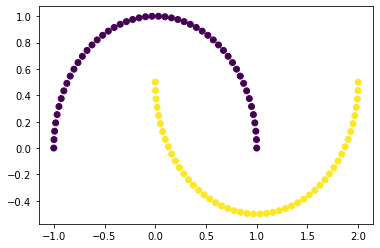

In [3]:
n_samples = 100
moons_data, moons_labels = skd.make_moons(n_samples=n_samples)
plt.scatter(moons_data.T[0], moons_data.T[1], c=moons_labels)
plt.show()

In [35]:
C_moons = dist_mat_exp_kernel(moons_data, sigma=1, eps=0.1)

In [36]:
res_moons = learn_k_component_graph(C_moons, k=2, maxiter=2000) #2000 or more in reality

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 100.36it/s]


In [49]:
score_moons = np.linalg.eig(res_moons["Laplacian"])[1][:, 1]
print("AUC score of the spectral classifier", skm.roc_auc_score(moons_labels, score_moons))

AUC score of the spectral classifier 1.0


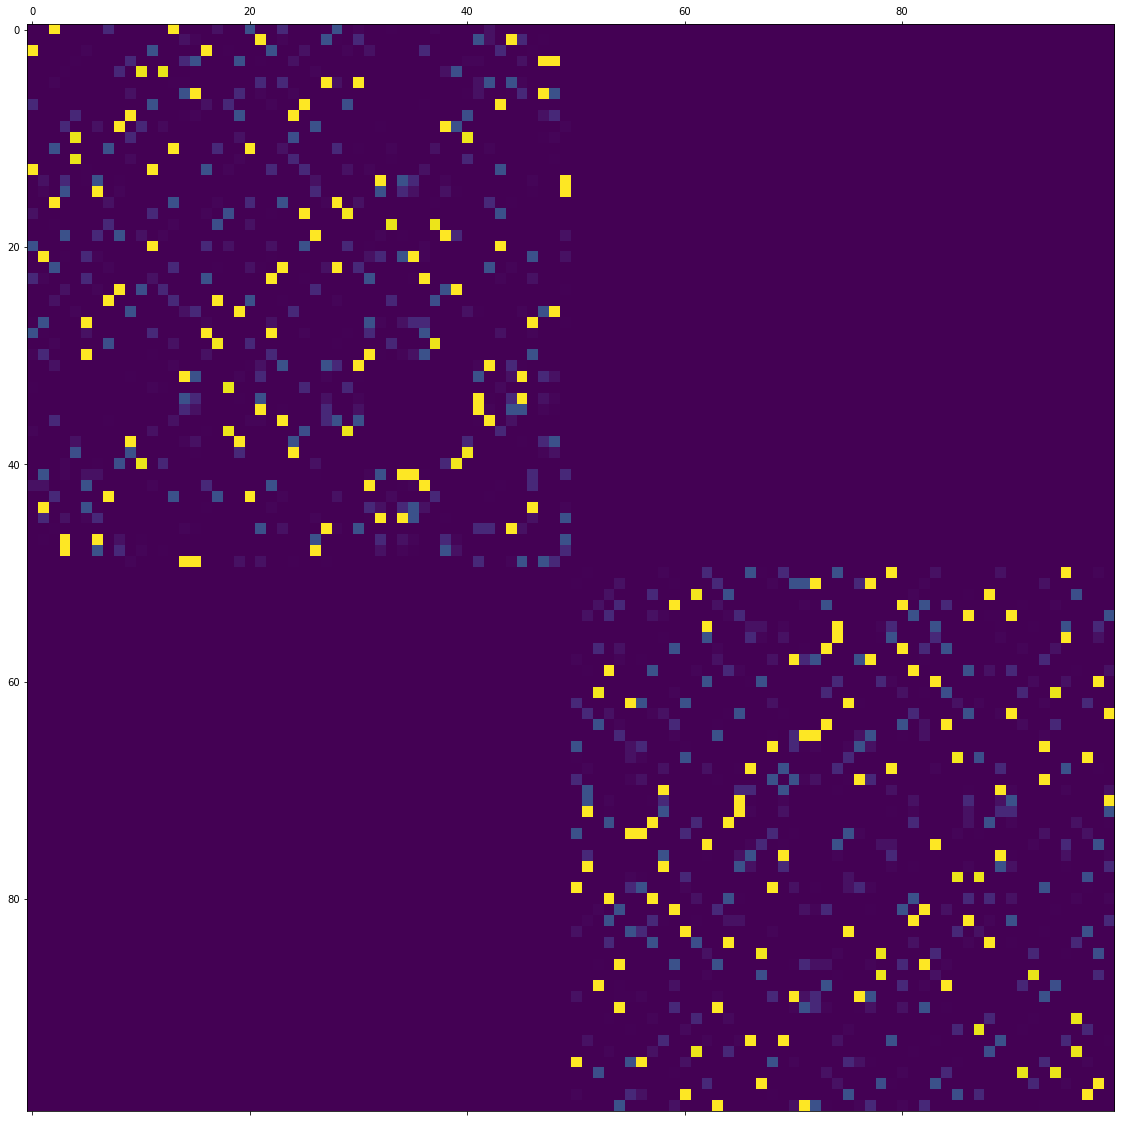

In [50]:
id_moons = np.argsort(moons_labels)
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_moons["Adjacency"][id_moons][:, id_moons], fignum=0)
plt.show()

We load the "two circles" dataset

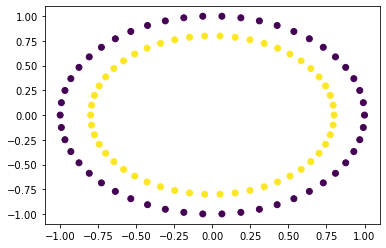

In [51]:
n_samples = 100
circles_data, circles_labels = skd.make_circles(n_samples=n_samples)
plt.scatter(circles_data.T[0], circles_data.T[1], c=circles_labels)
plt.show()

In [87]:
C_circles = dist_mat_exp_kernel(circles_data, k=2)
res_circles = learn_k_component_graph(C_circles, k=2, maxiter=200) #2000 or more in reality

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.54it/s]


In [88]:
score_circles = np.linalg.eig(res_circles["Laplacian"])[1][:, 1]
print("AUC score of the spectral classifier", skm.roc_auc_score(circles_labels, score_circles))

AUC score of the spectral classifier 0.522


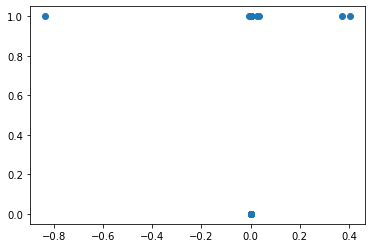

In [89]:
plt.scatter(score_circles, circles_labels)

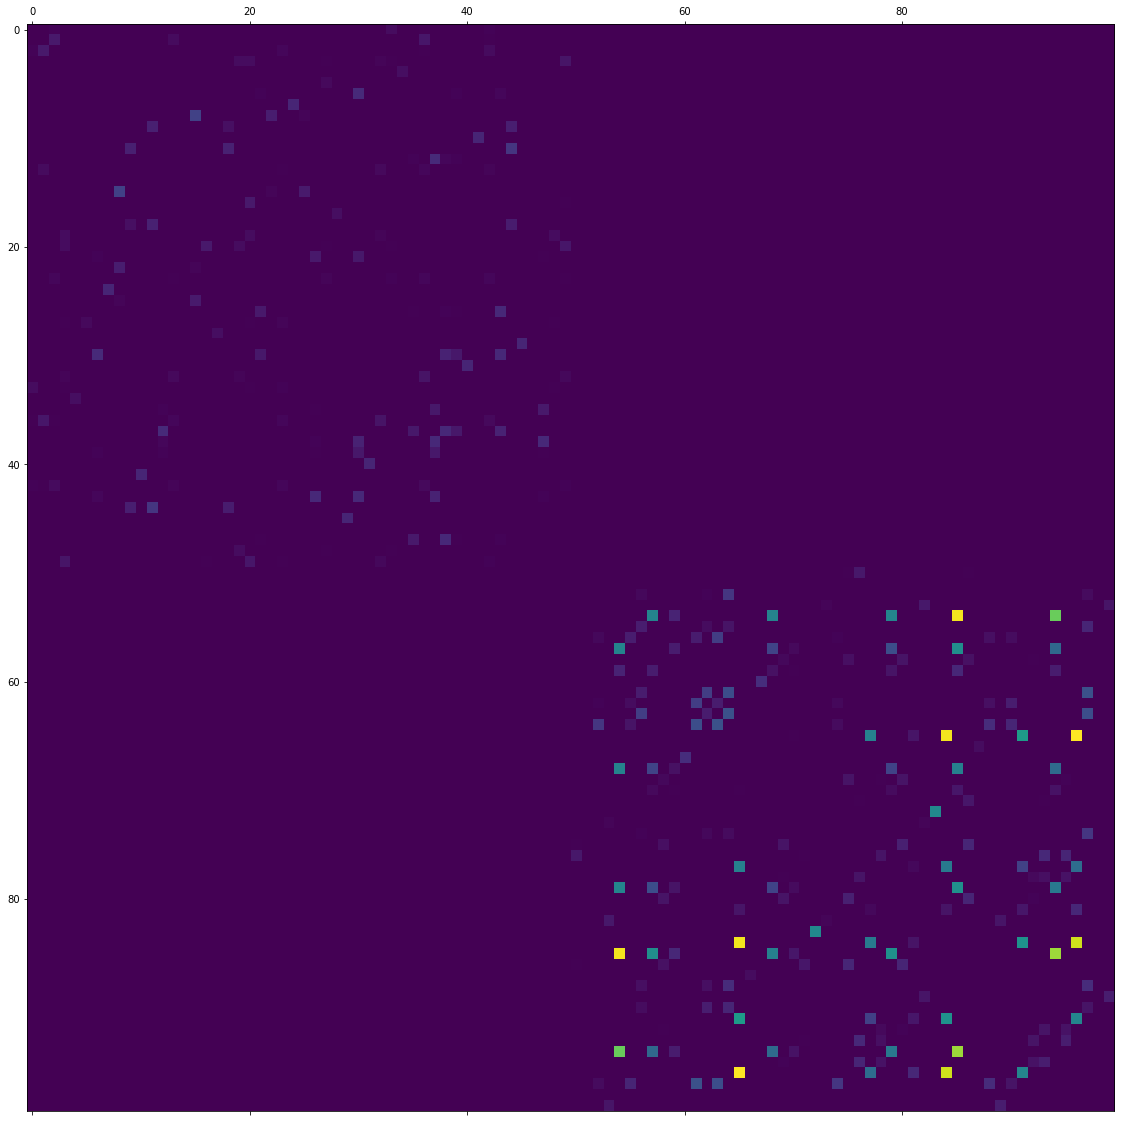

In [90]:
id_circles = np.argsort(circles_labels)
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_circles["Adjacency"][id_circles][:, id_circles], fignum=0)
plt.show()

## Gene dataset

This dataset come from https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#

It represents 801 patients with cancers of 5 different types

The features of the data are RNA-Seq gene expression levels

The label is the tumor type

To make the code work, download the dataset,extract it and save data and labels in the folder ./data/genes/

In [12]:
gene_df = pd.read_csv("data/genes/data.csv")
gene_df = gene_df[gene_df.columns[1:]]
gene_df

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [13]:
gene_labels = pd.read_csv("data/genes/labels.csv")
gene_labels = gene_labels[gene_labels.columns[1:]]
gene_labels

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA
...,...
796,BRCA
797,LUAD
798,COAD
799,PRAD


The goal is to model the distribution with a $k$ component graph, in order to clusetr the data into $k$ classes. As there are $k=5$ classes in reality, we try the algorithm with this value.

In [14]:
C = np.cov(gene_df.values)

In [15]:
res_genes = learn_k_component_graph(C, k=5, maxiter=20) #2000 or more in reality

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.47it/s]


Then, we reorganise the matrix according to their labels to see visually if the components that should be connected are effectively connected.

In [16]:
id_genes = np.argsort(gene_labels.values.squeeze())

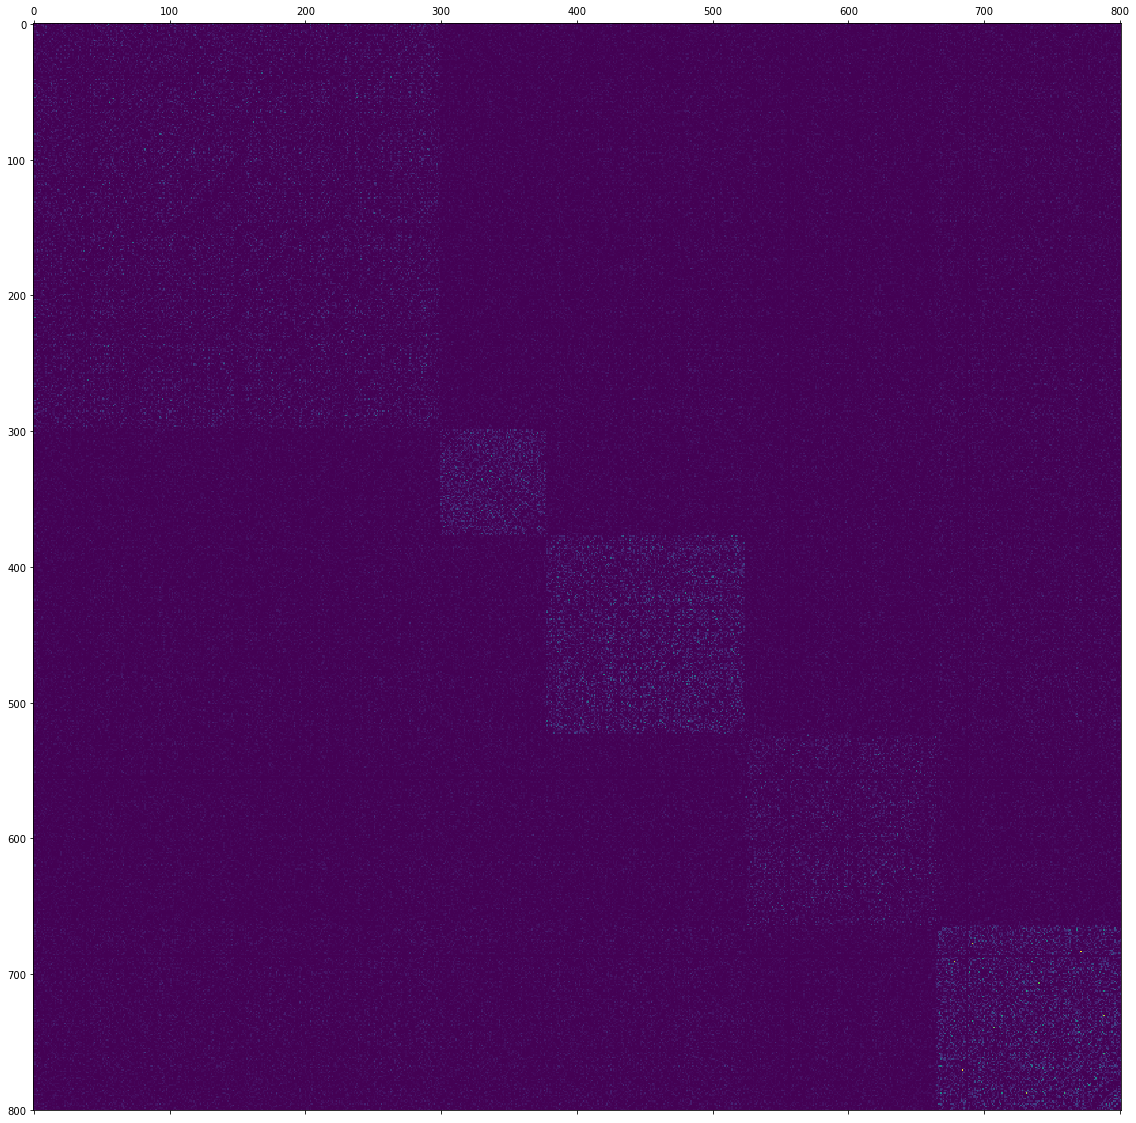

In [17]:
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_genes["Adjacency"][id_genes][:, id_genes], fignum=0)
plt.show()

In [18]:
print(np.sort(np.linalg.eig(res_genes["Laplacian"])[0]))

[-6.65088272e-16  1.00254277e+00  1.11032123e+00  1.11716432e+00
  1.40156880e+00  8.45463532e+00  8.58951532e+00  8.71183133e+00
  9.24333308e+00  9.33205527e+00  9.34924902e+00  9.41535491e+00
  9.51174792e+00  9.52158015e+00  9.56178001e+00  9.63452821e+00
  9.65345144e+00  9.78710995e+00  9.84893146e+00  9.86100335e+00
  9.88158817e+00  9.96169172e+00  9.99170068e+00  1.00219901e+01
  1.01129710e+01  1.02675164e+01  1.04079124e+01  1.04363510e+01
  1.04842883e+01  1.05230641e+01  1.06074240e+01  1.07217208e+01
  1.07826682e+01  1.08079372e+01  1.08247284e+01  1.08602083e+01
  1.09493370e+01  1.10028481e+01  1.10378852e+01  1.10509493e+01
  1.10962009e+01  1.11372354e+01  1.11511625e+01  1.11916565e+01
  1.12368035e+01  1.12697747e+01  1.12904742e+01  1.13229245e+01
  1.13825572e+01  1.14118379e+01  1.14244393e+01  1.14729956e+01
  1.15187155e+01  1.15481395e+01  1.15806658e+01  1.16060592e+01
  1.16387323e+01  1.16508615e+01  1.16857109e+01  1.16901708e+01
  1.17147963e+01  1.17219